# Quantum Evolution Simulator for Arbitrary 1D Potential

This Jupyter Notebook is created by Shrihan Agarwal @ UC Berkeley. The goal of this project was to generate the eigenvalues, eigenfunctions, and time evolution of any particle with an arbitrary wavefunction in any type of 1D potential well. Therefore, the input to the calculator is simply the 1D Potential you specify, and the initial state wavefunction of the particle. With this, we output the relevant eigenvalues, eigenfunctions, fourier decompositions, time evolutions, position expectations and position variance, and construct an animation to display them. 

This requires multiple steps:
1. Solving the Schrodinger equation numerically for any potential in 1D (the equation does not have general analytic solutions).
2. Obtaining the eigenfunctions corresponding to the relevant potential.
3. Decomposing an arbitrary input wavefunction into a fourier series of eigenfunctions for that potential.
4. Introducing time dependence for the eigenfunctions and using their linear combination to develop the time evolution of the decomposed wavefunction.
5. Combining and normalizing real and imaginary parts to obtain the observable position probability distribution, expectation and variance.

The below cell contains the necessary functions and equations that form the backbone of the simulator. After running the cell, move to the cell following it.

In [11]:
from scipy.integrate import odeint
import scipy.optimize as opt
import matplotlib.pyplot as plt  
import numpy as np
from matplotlib.animation import FuncAnimation
import time, sys
from IPython.display import clear_output


h_bar = 1
m_e = 1 


def update_progress(progress):
    """ @Source Bartosz Mikulski """
    
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


class Potential1D:
    """ Potential class holding relevant information for the 1D Potential environment. """
    V_scalar = 0
    particles = []
    start = 0
    end = 0
    steps = 0
    
    def __init__(self, V, start = -2, end = 2, steps = 1000):
        """ Initializes the potential. """
        self.V_scalar = V
        self.start = start
        self.end = end
        self.steps = steps
    
    def createParticle(self, mass, wav_func):
        """ Creates a particle in the potential. """
        new_part = Particle(mass, self)
        self.particles.append(new_part)
    
    def plotPotential(self):
        """ Plots a graph of the potential. """
        fig, ax = plt.subplots(1, 1, figsize = ((6, 5)))
        x = np.linspace(self.start, self.end, self.steps)
        ax.plot(x, [self.V_scalar(i) for i in x])
        ax.set_title("1D Potential")

class Particle:
    """ Class for a general particle in the potential in question. """
    mass = 0
    pot1D = 0
    wav_func = 0
    eigen_const = []
    eng_eigen = []
    norm_eigen = []
    
    def __init__(self, mass, pot1D, wav_func = None, eigen_constants = None, search_start = -0.2211, search_end = 15.8723, search_divisions = 100):
        """ Initializes the class variables, and searches/calculates eigen energies, functions and their fourier decomposition. """
        
        self.mass = mass
        self.pot1D = pot1D
        self.getEigenEnergyFunctions(search_start, search_end, search_divisions)
        
        if wav_func != None and eigen_constants == None:
            self.wav_func = wav_func
            self.eigen_const = self.calcEigenConstants()
        elif wav_func == None and eigen_constants != None:
            self.eigen_const = eigen_constants
        elif wav_func != None and eigen_constants != None:
            raise ValueError("Please enter only either a wave function, or a list of constants in combinations of eigenfunctions.")
        
    def psi(self, y, x, E):
        """ Helper function for numerical differentiation. Method sourced from @ Chemistry LibreTexts. """
        psi1, psi2_dx2 = y 
        return [psi2_dx2, ((-2 * self.mass)/(h_bar ** 2)) * (E * psi1 - self.pot1D.V_scalar(x) * psi1)]
    
    def calcEigenFunction(self, E):
        """ Calculates the eigenfunction based on the potential bounds and eigen-energy. Method sourced from @ Chemistry LibreTexts"""
        x0 = [0.0, 0.05]
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        sol = odeint(self.psi, x0, val, args = (E,))
        return sol[:, 0]
    
    def calcEndEigenFunction(self, E):
        """ Returns the last datapoint in the wavefunction, which should be minimized to zero. """
        return abs(self.calcEigenFunction(E)[-1])
    
    def calcEigenConstants(self):
        """ Calculates the fourier decomposition from the arbitrary input wavefunction to the eigenfunctions. """
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        wav_data = np.array([self.wav_func(i) for i in val])
        self.eigen_const = []

        for eigen_idx in range(len(self.eng_eigen)):
            prod = wav_data * self.norm_eigen[eigen_idx]
            cst = (np.sum(prod) * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps)
            self.eigen_const.append(cst)
            
        self.eigen_const = np.array(self.eigen_const)
        return self.eigen_const
    
    def countNodes(self,arr):
        """ Counts the number of nodes in a graph. """
        count = 0
        for elem_idx in range(len(arr) - 1):
            if arr[elem_idx] * arr[elem_idx + 1] < 0:
                count += 1
        return count
                

    def getEigenEnergyFunctions(self, search_start = -0.2211, search_end = 15.8723, search_divisions = 100):
        """ Calculates all the eigenvalues and eigenfunctions for the particle and stores them in class variables. """
        
        eng_eigen = []
        funcdata_eigen = []
        prev2 = [0, 0, 0]
        prev = [np.inf, np.inf, np.inf]
        curr = [0, 0, 0]
        diff = (search_end - search_start) / search_divisions
        g_count = 0
        e_count = 0
        space = np.linspace(search_start, search_end, search_divisions)
        eig_mins = []
        eig_nums = []
        
        for guess in space:

            min_E = opt.minimize_scalar(self.calcEndEigenFunction, 
                                        bounds = (guess - diff, guess + diff), 
                                        method = "bounded", options={'xatol': 1e-12})

            curr_func = self.calcEigenFunction(min_E.x)
            curr[0] = abs(curr_func[-1])
            curr[1] = min_E.x
            curr[2] = curr_func
            
            #print("Energy Eigenvalue: ", curr[1])
            #print("Minimizer: ", curr[0])
            #print("**********")
            
            if (prev[0] < prev2[0]) and (prev[0] < curr[0]):
                area = np.sqrt(np.sum(prev[2] ** 2) * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps)
                funcdata_eigen.append(prev[2] / area)
                eng_eigen.append(prev[1])
                eig_mins.append(prev[0])
                temp = funcdata_eigen[-1]
                nds = self.countNodes(temp[2:-2])
                update_progress(g_count / len(space))
                #if len(eng_eigen) > 0 and len(eig_mins) > 0:
                #    print("Last Energy Eigenvalue Found:", eng_eigen[-1])
                #    print("Minima Test (Should Be Close To Zero):", eig_mins[-1])

                assert nds == e_count, "Failed to find Eigenvalue #" + str(e_count + 1) + ". Got #" + str(nds + 1) +  ". Try increasing search_range or search_divisions.\n" #+ str(funcdata_eigen[-1])
                eig_nums.append(nds + 1)
                e_count += 1

            prev2 = prev[:]
            prev = curr[:]
            update_progress(g_count / len(space))
            if len(eng_eigen) > 0 and len(eig_mins) > 0:
                print("Found Eigenvalue Number:", e_count + 1)
                print("Energy:", eng_eigen[-1], "E_h")
                print("Minima Test (Should Be Close To Zero):", eig_mins[-1])

            g_count += 1
            
        self.eng_eigen = eng_eigen
        self.norm_eigen = funcdata_eigen 
        update_progress(1)
        return eng_eigen, funcdata_eigen
        
    def graphEigen(self, num = 4):
        """ Graphs the eigenfunctions upto the number inputted. """
        eng_eigen = self.eng_eigen[:num]
        fig, ax = plt.subplots(len(eng_eigen), 2, figsize = (12, 5 * len(eng_eigen)))
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)

        for i in (range(len(eng_eigen))):
            funcdata = self.norm_eigen[i]
            eng = eng_eigen[i]
            Vdata = [self.pot1D.V_scalar(i) for i in val]
            ax[0, 0].title.set_text("Generated Eigenfunctions")
            ax[0, 1].title.set_text("Energy Relative to Potential")
            ax[i, 0].plot(val, funcdata, label = str(i))
            ax[i, 1].plot(val, Vdata, color = "red")
            ax[i, 1].axhline(eng, color = "k", ls = "--")
            ax[i, 0].axhline(0, color = "k", ls = "--")
            maxima = max(funcdata[:int(self.pot1D.steps * 7/9)])
            ax[i, 0].set_ylim(- maxima - (7/9 * maxima), maxima + (7/9 * maxima))
            ax[i, 1].set_ylim(min(Vdata) - max(1, (1/9 * abs(min(Vdata)))), max(eng_eigen[-1] + (1/9 * eng_eigen[-1]), max(Vdata) + max(1, (1/9 * abs(max(Vdata))))))
            #ax[i, 1].set_ylim(-0.1, 2)

    def graphWavFuncOld(self, t = 0):
        """ Old graphing wavefunction. """
        
        fig, ax = plt.subplots(1, 2, figsize = (20, 10))
            
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        wav_data, wav_fourier, wav_eigen_t = self.calcWavFunc(t)
    
        
        for eigen_idx in range(len(self.eigen_const)):
            ax[1].plot(val, self.eigen_const[eigen_idx] * wav_eigen_t[0][eigen_idx], label = "Re:" + str(eigen_idx + 1))
            ax[1].plot(val, self.eigen_const[eigen_idx] * wav_eigen_t[1][eigen_idx], label = "Im:" + str(eigen_idx + 1))

        
        ax[0].plot(val, wav_fourier[0], label = "Re")
        ax[0].plot(val, wav_fourier[1], label = "Im")
        ax[0].plot(val, wav_data, ls = "--")
    
    def graphWavFunc(self, t = 0, anim = False, ex_arr = [], ylim = 0.7, ax = None):
        """ Final graphing function for all particle parameters. """
        if not anim:
            fig, ax = plt.subplots(2, 3, figsize = (20, 10))
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        wav_data, wav_fourier, wav_eigen_t = self.calcWavFunc(t)
        Vdata = [self.pot1D.V_scalar(i) for i in val]

        ax[0, 0].clear()
        ax[0, 1].clear()
        ax[0, 2].clear()
        ax[1, 0].clear()
        ax[1, 1].clear()
        ax[1, 2].clear()

        ax[0, 0].set_ylim((-1, 1))
        ax[0, 1].set_ylim((-0.1, ylim))
        ax[1, 0].set_ylim((-1, 1))
        ax[1, 1].set_ylim((-ylim, ylim))
        ax[1, 2].set_xlim((val[0] - 0.2, val[-1] + 0.2))
        diff = max(Vdata) - min(Vdata)
        y12ulim = max(Vdata) + diff / 2 + 0.5
        ax[0, 2].set_ylim(min(Vdata) - diff / 10 - 0.025, y12ulim)
        
        ax[0, 0].title.set_text("Fourier Decomposition - $Re(\psi)$")
        ax[0, 1].title.set_text("Position Probability Distribution")
        ax[0, 2].title.set_text("Potential Well Structure")
        ax[1, 0].title.set_text("Fourier Decomposition - $Im(\psi)$")
        ax[1, 1].title.set_text("Real & Imaginary Part of Wavefunction")
        ax[1, 2].title.set_text("Position Expectation / Standard Deviation")


        x = val
        y_re = wav_fourier[0]
        y_im = wav_fourier[1]
        prob = y_re ** 2 + y_im ** 2
        norm_prob = prob / np.sum(prob)
        
        ax[1, 1].plot(x, y_re, lw = 1.5)
        ax[1, 1].plot(x, y_im, lw = 1.5)
        ax[0, 1].plot(val, prob, lw = 2.5)
        ax[0, 2].plot(val, Vdata, color = "red", lw = 4)
        y_vert1 = np.linspace(Vdata[0], y12ulim + 0.1, 200)
        y_vert2 = np.linspace(Vdata[-1], y12ulim + 0.1, 200)
        ax[0, 2].plot([val[0] for i in range(200)], y_vert1, color = "red", lw = 4)
        ax[0, 2].plot([val[-1] for i in range(200)], y_vert2, color = "red", lw = 4)


        ax[0, 0].axhline(0, color = "k", ls = "--")
        ax[0, 1].axhline(0, color = "k", ls = "--")
        ax[1, 0].axhline(0, color = "k", ls = "--")
        ax[1, 1].axhline(0, color = "k", ls = "--")
        ex_xsqr = np.sum((x ** 2) * (prob) * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps) /  np.sum(prob * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps)
        ex_x = np.sum(x * (prob) * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps) / np.sum(prob * (self.pot1D.end - self.pot1D.start) / self.pot1D.steps)
        var_x = ex_xsqr - ex_x ** 2
        std_x = np.sqrt(var_x)
        
        
        if anim:
            ex_arr[0] = np.append(ex_arr[0], np.array([ex_x]))
            ex_arr[1] = np.append(ex_arr[1], np.array([std_x]))
            if len(ex_arr[0]) > 600:
                ex_arr[0] = np.delete(ex_arr[0], 0)
                ex_arr[1] = np.delete(ex_arr[1], 0)
        
        def x_index(x):
            return int((x - self.pot1D.start) / self.pot1D.steps)

        ax[0, 2].axvline(ex_x - std_x, lw = 2, ls = "--", color = colors[1])
        ax[0, 2].axvline(ex_x + std_x, lw = 2, ls = "--", color = colors[1])
        ax[0, 2].axvline(ex_x, lw = 3, color = colors[0])

        count = 0
        wav_eigen_t_re = wav_eigen_t[0]
        wav_eigen_t_im = wav_eigen_t[1]

        for eigen_t_re, eigen_t_im in list(zip(wav_eigen_t_re[:10][::-1], wav_eigen_t_im[:10][::-1])):

            font_dat = count / len(wav_eigen_t[0][:6])
            ax[0, 0].plot(val, eigen_t_re, color = colors[count], alpha = font_dat + 0.1, lw = 2 * font_dat, zorder = count)
            ax[1, 0].plot(val, eigen_t_im, color = colors[count], alpha = font_dat + 0.1, lw = 2 * font_dat, zorder = count)
            count += 1
        if anim:
            return ex_arr
            
    def calcWavFunc(self, t = 0):
        """ Calculates the time-evolution of all eigenfunctions and the overall wavefunction. """
        
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        wav_fourier_re = np.zeros(len(self.norm_eigen[0]))
        wav_fourier_im = np.zeros(len(self.norm_eigen[0]))
        wav_data = np.array([self.wav_func(i) for i in val])
        wav_eigen_t_re = []
        wav_eigen_t_im = []
        
        for eigen_idx in range(len(self.eigen_const)):
            norm_eigen_t_re = self.norm_eigen[eigen_idx] * np.cos(self.eng_eigen[eigen_idx] * t)
            norm_eigen_t_im = self.norm_eigen[eigen_idx] * np.sin(self.eng_eigen[eigen_idx] * t)
            wav_fourier_re += (self.eigen_const[eigen_idx] * norm_eigen_t_re)
            wav_fourier_im += (self.eigen_const[eigen_idx] * norm_eigen_t_im)
            wav_eigen_t_re.append(norm_eigen_t_re)
            wav_eigen_t_im.append(norm_eigen_t_im)
        
        wav_fourier = [wav_fourier_re, wav_fourier_im]
        wav_eigen_t = [wav_eigen_t_re, wav_eigen_t_im]
        
        return wav_data, wav_fourier, wav_eigen_t
    
    def animWavFunc(self, name, ylim = 0.7, t_start = 0, t_end = 20, t_step = (1 / 30)):
        """ Animates the time-evolution using matplotlib's animate and ffmpeg. """
        
        fig, ax = plt.subplots(2, 3, figsize = (20, 10))
        val = np.linspace(self.pot1D.start, self.pot1D.end, self.pot1D.steps)
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        ex_arr = [[], []]
        frm = int((t_end - t_start) / t_step)

        def init_func():
            return

        # animation function
        def animate(i):
            nonlocal ex_arr
            
            t = t_start + t_step * i
            ex_arr2 = self.graphWavFunc(t, anim = True, ex_arr = ex_arr, ylim = ylim, ax = ax)
            list_len_exarr = list(range(len(ex_arr[0])))
            ex_x = ex_arr2[0]
            std_x = ex_arr2[1]
            ax[1, 2].plot(ex_x, list_len_exarr, lw = 3, color = colors[0])
            ax[1, 2].plot(ex_x + std_x, list_len_exarr, lw = 2, ls = "--", color = colors[1])
            ax[1, 2].plot(ex_x - std_x, list_len_exarr, lw = 2, ls = "--", color = colors[1])
            ex_arr = ex_arr2[:]
            update_progress(i / frm)
                    
        anim = FuncAnimation(fig, animate, init_func = init_func,
                                    frames = frm, interval = 20)
        
        anim.save(name, writer = 'ffmpeg', fps = 30)
        
        update_progress(1)
        
        return anim

Next, we choose a potential that our particle will be within. Note that the particle will be eventually confined by infinite walls at the boundary of the potential, to ensure that the wavefunctions go to zero at the bounds. A few examples are provided below.

In [12]:
 def V(x):
    #return 0                                     # Infinite-Square Well
    #return x                                     # Sloped-Well
    return (0.5 * (x ** 2))                       # Harmonic Oscillator

Here, we instantiate a Potential1D object based on the potential that we have created above. The bounds for the potential are set to [$-\pi$,$\pi$]. A larger potential requires heavier numerical computation and accuracy, and is not recommended for this simulator.

In [13]:
pot = Potential1D(V, start = -1 * np.pi, end = 1 * np.pi)

We can plot our potential to ensure that it is correct using the following.

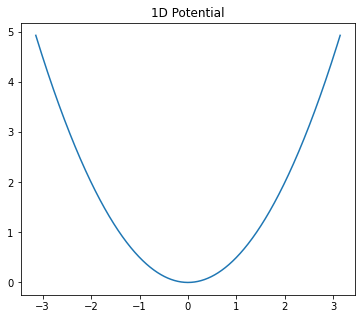

In [14]:
pot.plotPotential()

We then describe the initial state wavefunction of the particle. This wavefunction will be decomposed into eigenfunctions of our potential in the future steps. A suggestion is to choose a wavefunction whose range is bounded between 0 and 1, otherwise the y-limits on graphs will need to be set manually.

In [15]:
def func(x):
    #return 0.5 * np.sin(x)                       # Sine Wave
    #return 0.5                                   # Constant
    return 0.7 * np.exp(-(x + 2) ** 2 / 0.1)      # Gaussian centered at -2, of height 0.7 and std 0.1

Now that we have all the necessary inputs to define our potential/wavefunction pair, we can create our particle. We have to specify the mass (_in natural units_) and potential object from before, along with the wavefunction chosen. In this step, we also calculate the eigenfunctions of our potential, and decompose our chosen wavefunction into them. You may need to search a wider range or increase the search divisions based on your chosen potential, especially if the calculator misses an eigenfunction.

NOTE: Since we calculate in natural units, energies shown are approximately related as 1 $E_h$ = 27.2 $eV$.

In [16]:
part = Particle(m_e, pot, wav_func = func, search_start = -1, search_end = 100, search_divisions = 600)

Progress: [####################] 100.0%


We can then plot the first few eigenfunctions as a check to make sure that the calculator successfully found them through numerical means.

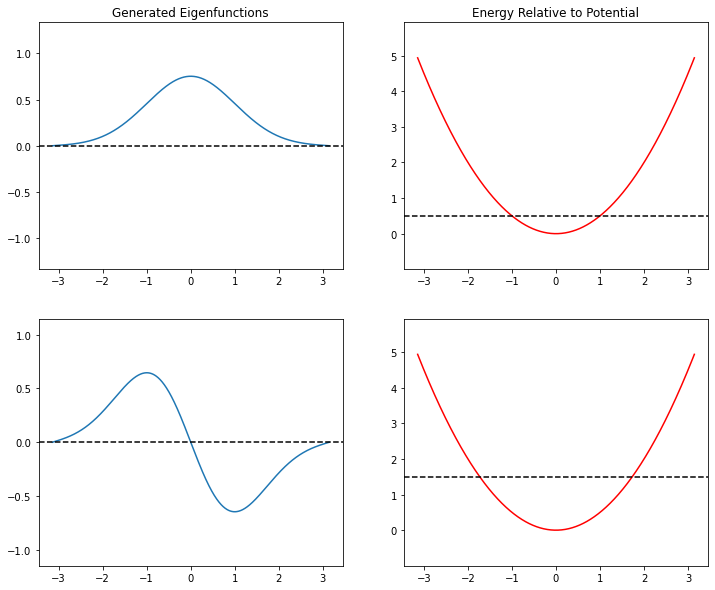

In [17]:
part.graphEigen(2)

In fact, we already have the necessary information to plot the time evolution of our wavefunction! You can input a time and run the function below to see the time evolution of the particle, along with multiple other calculated parameters.

NOTE: The bottom right plot will not function until the animation stage of the notebook.

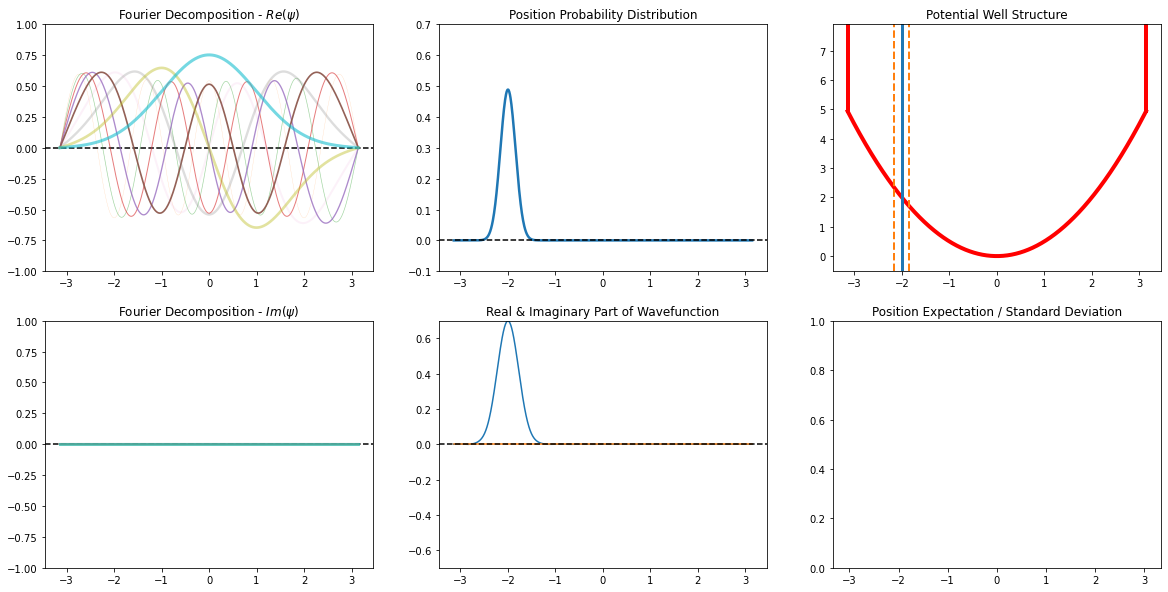

In [18]:
part.graphWavFunc(t = 0)

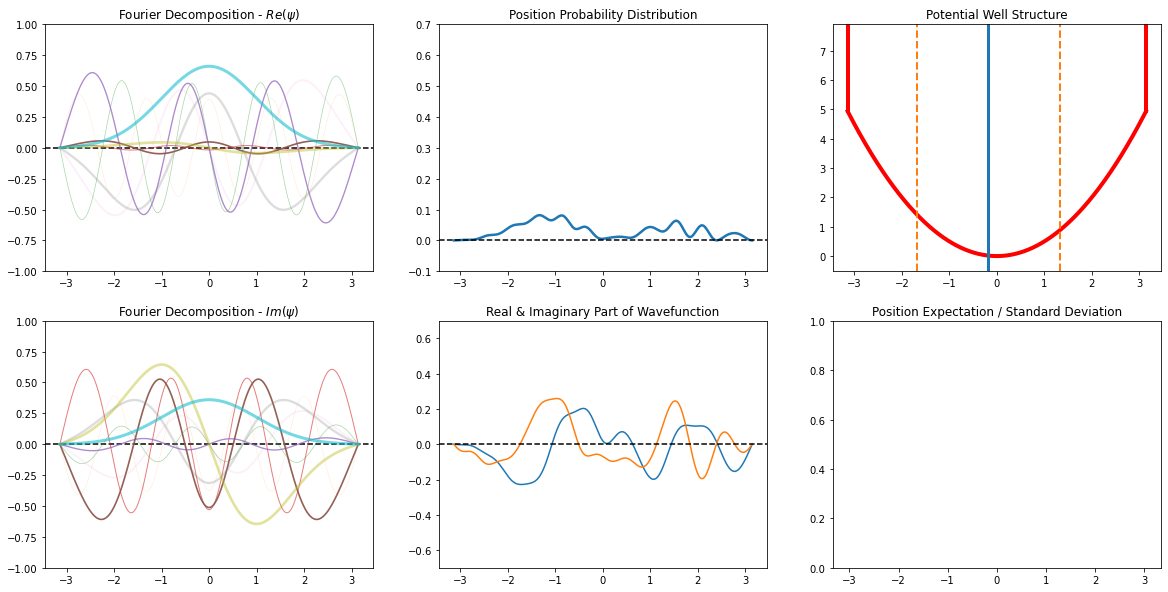

In [19]:
part.graphWavFunc(t = 1)

With this step, we can finally animate our graphs to visualize the time evolution of our particle in 1D. Note that this step requires you to have installed "ffmpeg" which gives matplotlib the necessary tools to generate the animation. A guide to installing ffmpeg can be found here: https://anaconda.org/conda-forge/ffmpeg or by running `pip install ffmpeg` in your terminal.

You can also specify the time interval between frames and start and end time for the particle in the animation, depending on the speed and range that you prefer. This step will take a while since matplotlib has to generate $(t_{end} - t_{start}) \, / \, t_{step} $ frames, so a progress bar has been added. The video file will play at 30 frames per second, and will be stored in the same directory as the jupyter notebook. 

In [ ]:
part.animWavFunc("GaussianFunc_Harmonic3.mp4", t_step = 1 / 150 * np.pi, t_start = 0, t_end = 8 * np.pi)

Progress: [###############-----] 74.0%
